In [1021]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import calendar
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from collections import Counter

In [1025]:
"""
# Get forums

r = requests.get("https://community.screwfix.com/forums/")
soup = BeautifulSoup(r.text, "html.parser")

forum_urls = []

for link in soup.find_all("a", href=re.compile("^(?!.*rss$)forums.*")):
    forum_urls.append(link["href"])

forum_slugs = list(set(forum_urls))
forum_slugs.remove("forums/#screwfix-community-forum.1")
forum_slugs.remove("forums/the-small-print.2027/")

#print(forum_slugs)

# Get posts

data = []

for slug in forum_slugs:
    i = 1
    status_code = 200
    while status_code == 200:
        if i == 1:
            url = "https://community.screwfix.com/" + slug
        else:
            url = "https://community.screwfix.com/" + slug + "page-" + str(i)
        r = requests.get(url, allow_redirects=False)
        status_code = r.status_code
        soup = BeautifulSoup(r.text, "html.parser")
        for post in soup.find_all("li", class_="discussionListItem"):
            title = post.find("h3", class_="title").text.strip()
            date = post.find("span", class_=["startDate", "DateTime"]).text.replace(",", "").strip()
            data.append({"forum": slug, "title":title, "date": date})
        #print(slug, str(i))
        i += 1

pd.DataFrame(data).to_csv("screwfix.csv", index=False)
""";

In [1026]:
# Import the data and format

data = pd.read_csv("/Users/jamie/Downloads/screwfix.csv")
data = data[["forum", "title", "date"]]
data.drop_duplicates(inplace=True)
data["datetime"] = pd.to_datetime(data["date"], infer_datetime_format=True)
data = data.loc[
    (data["datetime"].dt.year > 2015) &
    (data["datetime"].dt.year < 2021)
]
data["forum"] = data["forum"].apply(
    lambda x: x.replace("/", ".").split(".")[1] # Simplify forum name
)

'Every 40 minutes in 2020, someone started a new post'

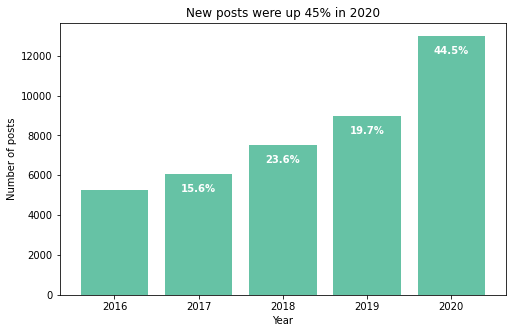

In [1027]:
# Posts per year

posts_per_year = data.groupby(
    data["datetime"].dt.year
)["title"].count()

ax = posts_per_year.plot(
    figsize=(8,5),
    kind="bar",
    width=.8,
    cmap="Set2",
    rot=0,
    xlabel="Year",
    ylabel="Number of posts",
    title="New posts were up 45% in 2020"
)

for rect, label in zip(ax.patches, posts_per_year.pct_change()):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() - 500,
        f"{label:.1%}" if label > 0 else "",
        weight="bold",
        ha="center",
        va="top",
        c="w"
    )

f"Every {1/(posts_per_year.max()/365/24/60):.0f} minutes in 2020, someone started a new post"

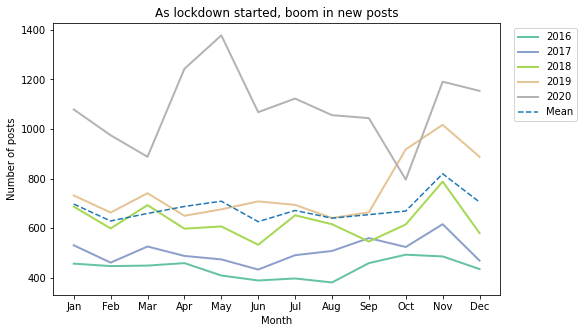

In [1030]:
# Posts per month

posts_per_month_year = data.groupby([
    data["datetime"].dt.month,
    data["datetime"].dt.year
])["title"].count().unstack()

posts_per_month_mean = data.groupby([
    data["datetime"].dt.month,
    data["datetime"].dt.year
])["title"].count().unstack(level=0).mean().rename("Mean")

ax = posts_per_month_year.plot(
    figsize=(8,5),
    kind="line",
    cmap="Set2",
    lw=2,
    xticks=range(1,13), # Force xticks
    ylabel="Number of posts",
    title="As lockdown started, boom in new posts"
)

posts_per_month_mean.plot(ax=ax, style=["--"], xlabel="Month")

ax.set_xticklabels(calendar.month_abbr[1:])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

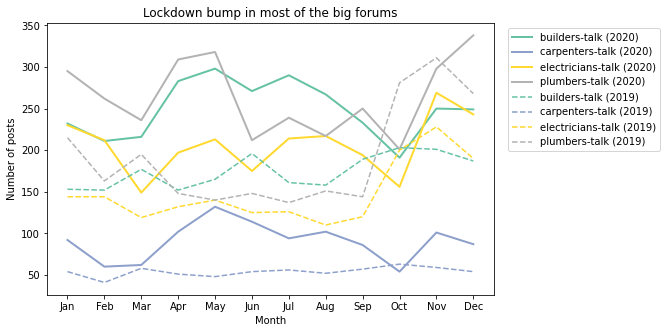

In [1034]:
# Posts per month by forum

forums = data["forum"].value_counts() > 2500
forums = forums[forums].index.to_list() # Get more popular forums

posts_per_month_forum_2020 = data.loc[
    (data["datetime"].dt.year == 2020) &
    (data["forum"].isin(forums))
].groupby([
    data["datetime"].dt.month,
    data["forum"]
])["title"].count().unstack()

posts_per_month_forum_2020.columns = [c + " (2020)" for c in posts_per_month_forum_2020.columns]

posts_per_month_forum_2019 = data.loc[
    (data["datetime"].dt.year == 2019) &
    (data["forum"].isin(forums))
].groupby([
    data["datetime"].dt.month,
    data["forum"]
])["title"].count().unstack()

posts_per_month_forum_2019.columns = [c + " (2019)" for c in posts_per_month_forum_2019.columns]

ax = posts_per_month_forum_2020.plot(
    figsize=(8,5),
    kind="line",
    cmap="Set2",
    lw=2,
    xticks=range(1,13), # Force xticks
    ylabel="Number of posts",
    title="Lockdown bump in most of the big forums"
)

posts_per_month_forum_2019.plot(
    ax=ax,
    cmap="Set2",
    style=["--" for l in posts_per_month_forum_mean.columns],
    xlabel="Month",
)

ax.set_xticklabels(calendar.month_abbr[1:])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

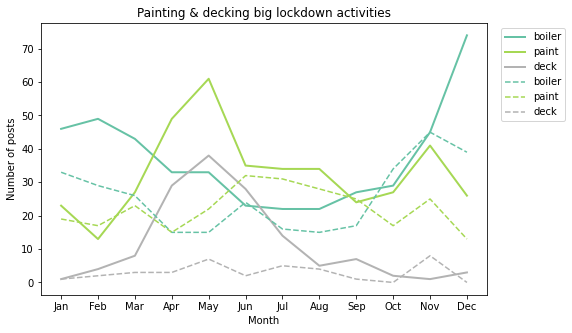

In [1079]:
# Search terms by month

terms = ["boiler", "paint", "deck"]
terms_regex = "|".join([f"(?P<{t}>{t})" for t in terms])

data_terms_2020 = data.loc[
    data["datetime"].dt.year == 2020
].merge(
    data["title"].str.extract(rf"{terms_regex}", flags=re.IGNORECASE),
    left_index=True,
    right_index=True
)

data_terms_by_month_2020 = data_terms_2020[terms].groupby([
    data_terms_2020["datetime"].dt.month,
]).count()

data_terms_2019 = data.loc[
    data["datetime"].dt.year == 2019
].merge(
    data["title"].str.extract(rf"{terms_regex}", flags=re.IGNORECASE),
    left_index=True,
    right_index=True
)

data_terms_by_month_2019 = data_terms_2019[terms].groupby([
    data_terms_2019["datetime"].dt.month,
]).count()

ax = data_terms_by_month_2020.plot(
    figsize=(8,5),
    kind="line",
    cmap="Set2",
    lw=2,
    xticks=range(1,13), # Force xticks
    xlabel="Month",
    ylabel="Number of posts",
    title="Painting & decking big lockdown activities"
)

data_terms_by_month_2019.plot(
    ax=ax,
    cmap="Set2",
    style=["--" for l in posts_per_month_forum_mean.columns],
    xlabel="Month"
)

ax.set_xticklabels(calendar.month_abbr[1:])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

In [1116]:
%%time

# Uncover other topics by clustering

v = TfidfVectorizer(stop_words="english", min_df=100)
data_2020 = data.loc[data["datetime"].dt.year == 2020].copy().reset_index()
tfidf = v.fit_transform(data_2020["title"])
clusterer = DBSCAN(
    eps=.2, # Your guess is as good as mine
    min_samples=10,
    metric="cosine"
).fit(tfidf)
data_2020["cluster"] = clusterer.labels_
    
# Generate keywords per cluster

keywords = {}
for name, cluster in data_2020.groupby("cluster"):
    kw = []
    for index in cluster.index:
        kw = kw + [v.get_feature_names()[i] for i in tfidf[index].indices]
    keywords[name] = ", ".join([t for t, c in Counter(kw).most_common(5)])

keywords = pd.DataFrame.from_dict(
    keywords,
    orient="index",
    columns=["cluster_desc"]
).reset_index().rename(columns={"index": "cluster"})

data_2020 = data_2020.merge(keywords, on="cluster")

print(data_2020["cluster"].unique())

[-1  0  1  2 45  3 21  4  6  5  7  8  9 10 11 12 13 14 15 16 17 18 19 24
 20 68 22 23 25 90 26 27 28 29 30 31 32 33 34 35 36 58 37 38 39 40 84 41
 42 43 44 46 47 48 49 50 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 85
 69 82 67 79 78 70 89 71 72 73 83 74 75 77 76 80 81 87 86 88]
CPU times: user 4.4 s, sys: 600 ms, total: 5 s
Wall time: 5.37 s


<AxesSubplot:xlabel='0', ylabel='1'>

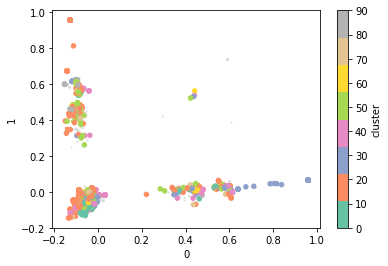

In [1113]:
# Visualise

pca = pd.DataFrame(PCA(n_components=2).fit_transform(tfidf.todense()))
pca["cluster"] = clusterer.labels_

ax = pca.loc[pca["cluster"] == -1].plot(
    kind="scatter",
    x=0,
    y=1,
    c="lightgrey",
    alpha=.5,
    s=2
)

pca.loc[pca["cluster"] != -1].plot(
    kind="scatter",
    x=0,
    y=1,
    c="cluster",
    cmap="Set2",
    ax=ax
)

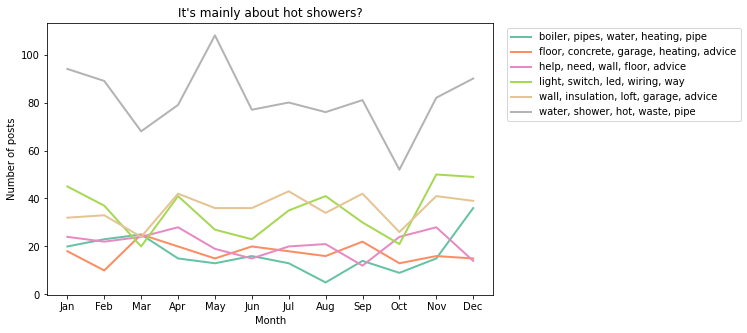

In [1115]:
# Clusters by month

clusters = data_2020["cluster"].value_counts() > 200
clusters = clusters[clusters].index.to_list() # Get more popular clusters
clusters.remove(-1)

posts_per_month_cluster_2020 = data_2020.loc[
    data_2020["cluster"].isin(clusters)
].groupby([
    data_2020["datetime"].dt.month,
    data_2020["cluster_desc"]
])["title"].count().unstack()

ax = posts_per_month_cluster_2020.plot(
    figsize=(8,5),
    kind="line",
    cmap="Set2",
    lw=2,
    xticks=range(1,13), # Force xticks
    xlabel="Month",
    ylabel="Number of posts",
    title="It's mainly about hot showers?"
)

ax.set_xticklabels(calendar.month_abbr[1:])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")